In [1]:
from google.colab import auth
auth.authenticate_user()

In [2]:
!pip install --upgrade google-cloud-storage


In [3]:
from google.cloud import storage
import pandas as pd

In [4]:
from google.cloud import storage
import pandas as pd

# Initialize the GCP Storage client
gcp_client = storage.Client()

# Define bucket and file names
bucket_name = 'air_quality_bucket_sponduru'
dataset_file = 'AQI_and_Lat_Long_of_Countries.csv'

# Access the bucket and download the file
bucket = gcp_client.get_bucket(bucket_name)
dataset_blob = bucket.blob(dataset_file)
dataset_blob.download_to_filename(dataset_file)

# Load the dataset into a Pandas DataFrame
air_quality_df = pd.read_csv(dataset_file)

# Display the first few rows of the dataset
print(air_quality_df.head())


              Country              City  AQI Value AQI Category  CO AQI Value  \
0  Russian Federation        Praskoveya         51     Moderate             1   
1              Brazil  Presidente Dutra         41         Good             1   
2              Brazil  Presidente Dutra         41         Good             1   
3               Italy   Priolo Gargallo         66     Moderate             1   
4              Poland         Przasnysz         34         Good             1   

  CO AQI Category  Ozone AQI Value Ozone AQI Category  NO2 AQI Value  \
0            Good               36               Good              0   
1            Good                5               Good              1   
2            Good                5               Good              1   
3            Good               39               Good              2   
4            Good               34               Good              0   

  NO2 AQI Category  PM2.5 AQI Value PM2.5 AQI Category      lat      lng  
0    

In [5]:
print(air_quality_df.isnull().sum())


Country               302
City                    0
AQI Value               0
AQI Category            0
CO AQI Value            0
CO AQI Category         0
Ozone AQI Value         0
Ozone AQI Category      0
NO2 AQI Value           0
NO2 AQI Category        0
PM2.5 AQI Value         0
PM2.5 AQI Category      0
lat                     0
lng                     0
dtype: int64


In [6]:
air_quality_df = air_quality_df.dropna(subset=['Country'])


In [7]:
print(air_quality_df.isnull().sum())


Country               0
City                  0
AQI Value             0
AQI Category          0
CO AQI Value          0
CO AQI Category       0
Ozone AQI Value       0
Ozone AQI Category    0
NO2 AQI Value         0
NO2 AQI Category      0
PM2.5 AQI Value       0
PM2.5 AQI Category    0
lat                   0
lng                   0
dtype: int64


In [8]:
# Define pollutant columns
pollutant_columns = ['CO AQI Value', 'Ozone AQI Value', 'NO2 AQI Value', 'PM2.5 AQI Value']

# Remove outliers beyond the 1th and 99th percentiles
for col in pollutant_columns:
    lower_bound = air_quality_df[col].quantile(0.01)
    upper_bound = air_quality_df[col].quantile(0.995)
    air_quality_df = air_quality_df[(air_quality_df[col] >= lower_bound) & (air_quality_df[col] <= upper_bound)]

# Verify changes
print(f"Dataset shape after outlier removal: {air_quality_df.shape}")


Dataset shape after outlier removal: (15784, 14)


In [9]:
# Rename pollutant columns for clarity
air_quality_df.rename(columns={
    'CO AQI Value': 'CO_Level',
    'Ozone AQI Value': 'Ozone_Level',
    'NO2 AQI Value': 'NO2_Level',
    'PM2.5 AQI Value': 'PM25_Level',
    'lat': 'Lat',
    'lng': 'Long',
    'AQI Value': 'AQI_Value'
}, inplace=True)

air_quality_df.rename(columns={'PM2.5 AQI Category': 'PM25_AQI_Category'}, inplace=True)

# Verify column names
print(air_quality_df.columns)


Index(['Country', 'City', 'AQI_Value', 'AQI Category', 'CO_Level',
       'CO AQI Category', 'Ozone_Level', 'Ozone AQI Category', 'NO2_Level',
       'NO2 AQI Category', 'PM25_Level', 'PM25_AQI_Category', 'Lat', 'Long'],
      dtype='object')


In [10]:
# Check for duplicates
print(f"Number of duplicate rows: {air_quality_df.duplicated().sum()}")

# Drop duplicates
air_quality_df.drop_duplicates(inplace=True)

# Verify
print(f"Dataset shape after removing duplicates: {air_quality_df.shape}")


Number of duplicate rows: 0
Dataset shape after removing duplicates: (15784, 14)


Country
United States of America                                3872
Germany                                                 1072
Italy                                                    866
Russian Federation                                       844
Brazil                                                   836
India                                                    708
Japan                                                    495
France                                                   454
United Kingdom of Great Britain and Northern Ireland     453
China                                                    378
Name: count, dtype: int64


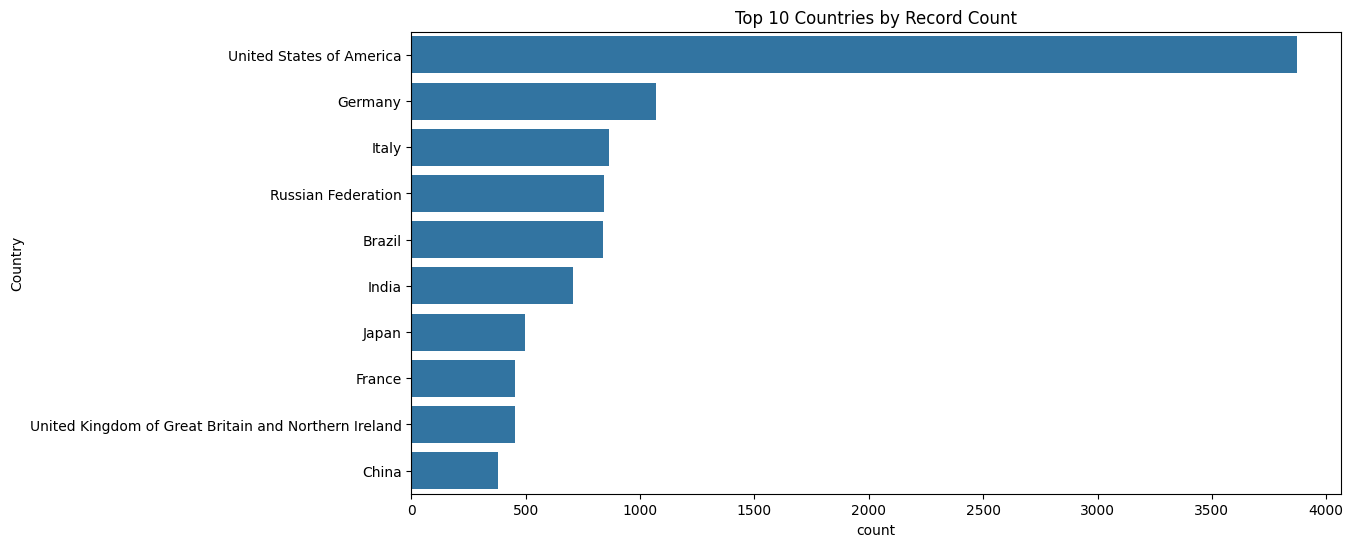

In [11]:
# Top 10 countries by record count
print(air_quality_df['Country'].value_counts().head(10))

# Visualize country distribution
import seaborn as sns
import matplotlib.pyplot as plt

plt.figure(figsize=(12, 6))
sns.countplot(y=air_quality_df['Country'], order=air_quality_df['Country'].value_counts().head(10).index)
plt.title('Top 10 Countries by Record Count')
plt.show()


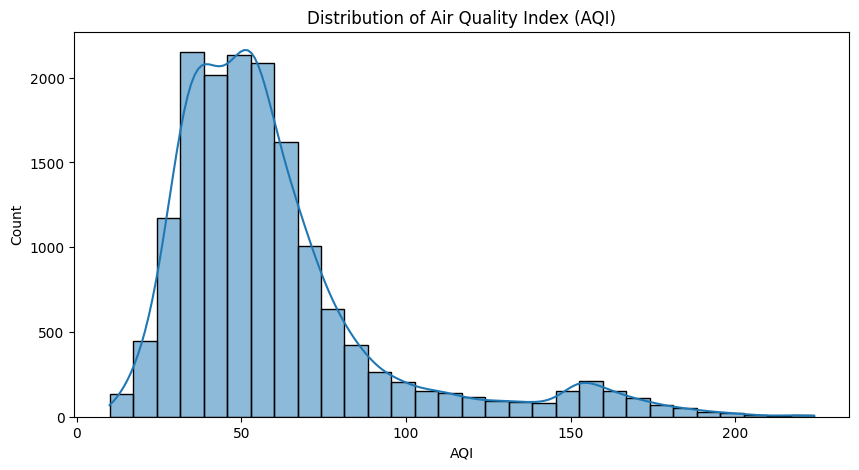

In [12]:
# Plot histogram for AQI levels
plt.figure(figsize=(10, 5))
sns.histplot(air_quality_df['AQI_Value'], kde=True, bins=30)
plt.title('Distribution of Air Quality Index (AQI)')
plt.xlabel('AQI')
plt.show()


             CO_Level  Ozone_Level  NO2_Level  PM25_Level  AQI_Value
CO_Level     1.000000     0.098270   0.507050    0.610494   0.621494
Ozone_Level  0.098270     1.000000  -0.272719    0.217678   0.328603
NO2_Level    0.507050    -0.272719   1.000000    0.314295   0.284000
PM25_Level   0.610494     0.217678   0.314295    1.000000   0.975422
AQI_Value    0.621494     0.328603   0.284000    0.975422   1.000000


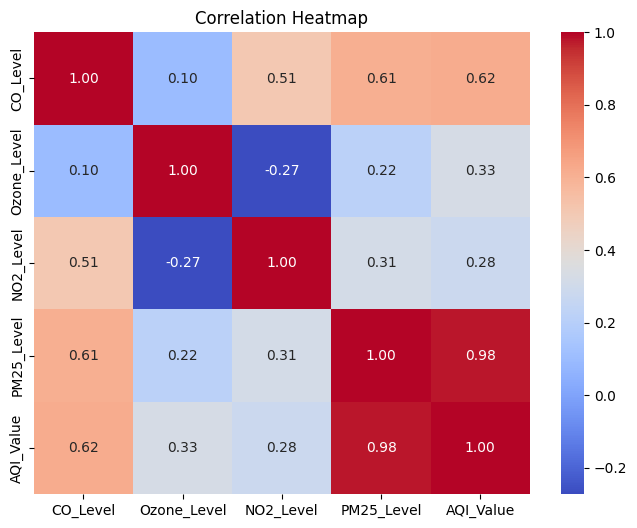

In [13]:
# Calculate correlation matrix
correlation_matrix = air_quality_df[['CO_Level', 'Ozone_Level', 'NO2_Level', 'PM25_Level', 'AQI_Value']].corr()
print(correlation_matrix)

# Visualize correlation heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Heatmap')
plt.show()


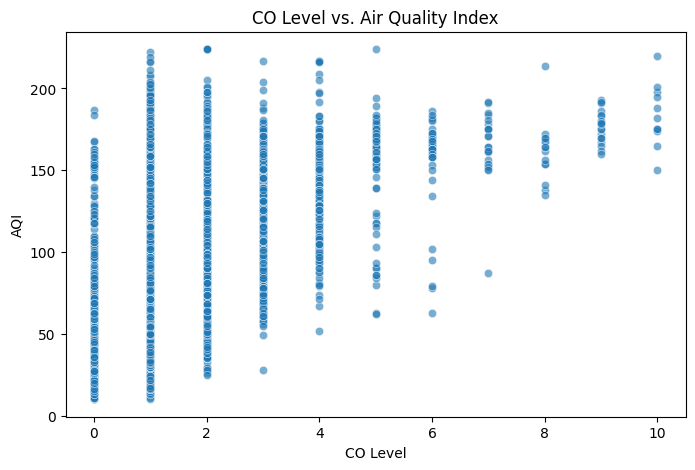

In [14]:
# Scatter plot for CO_Level vs AQI
plt.figure(figsize=(8, 5))
sns.scatterplot(data=air_quality_df, x='CO_Level', y='AQI_Value', alpha=0.6)
plt.title('CO Level vs. Air Quality Index')
plt.xlabel('CO Level')
plt.ylabel('AQI')
plt.show()


In [15]:
import folium

# Create a map centered around the dataset's mean coordinates
map_center = [air_quality_df['Lat'].mean(), air_quality_df['Long'].mean()]
air_quality_map = folium.Map(location=map_center, zoom_start=5)

# Add AQI data points to the map
for _, row in air_quality_df.iterrows():
    folium.CircleMarker(
        location=[row['Lat'], row['Long']],
        radius=5,
        popup=f"AQI: {row['AQI_Value']}",
        color='red' if row['AQI_Value'] > 100 else 'green',
        fill=True,
        fill_opacity=0.7
    ).add_to(air_quality_map)

air_quality_map.save('air_quality_map.html')
print("Map saved as air_quality_map.html.")


Map saved as air_quality_map.html.


In [16]:
# Using Z-score to remove outliers
from scipy.stats import zscore

# Filter pollutants
pollutant_cols = ['CO_Level', 'Ozone_Level', 'NO2_Level', 'PM25_Level']
air_quality_df = air_quality_df[(zscore(air_quality_df[pollutant_cols]) < 3).all(axis=1)]


# Verify
print(f"Dataset shape after removing duplicates: {air_quality_df.shape}")


Dataset shape after removing duplicates: (14790, 14)


In [20]:
air_quality_df['AQI_Value'] = pd.to_numeric(air_quality_df['AQI_Value'], errors='coerce')
print(air_quality_df['AQI_Value'].isnull().sum())  # Check for invalid values


0


In [21]:
air_quality_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 14790 entries, 0 to 16694
Data columns (total 14 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   Country             14790 non-null  object 
 1   City                14790 non-null  object 
 2   AQI_Value           14790 non-null  int64  
 3   AQI Category        14790 non-null  object 
 4   CO_Level            14790 non-null  int64  
 5   CO AQI Category     14790 non-null  object 
 6   Ozone_Level         14790 non-null  int64  
 7   Ozone AQI Category  14790 non-null  object 
 8   NO2_Level           14790 non-null  int64  
 9   NO2 AQI Category    14790 non-null  object 
 10  PM25_Level          14790 non-null  int64  
 11  PM25_AQI_Category   14790 non-null  object 
 12  Lat                 14790 non-null  float64
 13  Long                14790 non-null  float64
dtypes: float64(2), int64(5), object(7)
memory usage: 1.7+ MB


In [22]:
# Save the cleaned dataset locally
cleaned_file_name = 'cleaned_air_quality_data.csv'
air_quality_df.to_csv(cleaned_file_name, index=False, encoding='utf-8')
print(f"Cleaned dataset saved as {cleaned_file_name}")


Cleaned dataset saved as cleaned_air_quality_data.csv


In [23]:
# Upload cleaned dataset back to GCP
cleaned_blob = bucket.blob('cleaned_air_quality_data.csv')  # Rename for uniqueness
cleaned_blob.upload_from_filename(cleaned_file_name)
print("Cleaned dataset uploaded to GCP bucket.")


Cleaned dataset uploaded to GCP bucket.
